In [1]:
from numbers_parser import Document
import pandas as pd
import glob,os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy.optimize import minimize,root_scalar

/Users/manuel/miniconda3/lib/python3.9/site-packages/numbers_parser/__init__.py:68: UserWarning: Numbers version 13.1 not tested with this version


In [2]:
class Energy:
    def __init__(self,production_params=None,usage_params=None,last_d=None) -> None:
        if production_params is None:
            self.production_params = np.array([5,30, 10])
        else:
            self.production_params=production_params

        if usage_params is None:
            self.usage_params = np.array([20, -10, 15])
        else:
            self.usage_params=usage_params
        self.d0=datetime(2023,1,1)
        if last_d is None:
            self.last_d = self.d0+timedelta(days=1000)
        else:
            self.last_d=last_d


    def load_meter(self,file):
        doc = Document(file)
        sheets = doc.sheets()
        s = sheets['Electricity']
        data = s.tables['Inputs'].rows(values_only=True)
        meter = pd.DataFrame(data[1:], columns=data[0])[['Date ', 'Meter']]
        meter = meter.rename(columns={x:x.lower().replace(' ','') for x in meter.columns})
        meter['date']=[x.replace(tzinfo=None) for x in meter['date']]
        meter['from']=meter['date'].shift(1)
        meter['to']=meter['date']
        meter['net_used'] = meter['meter'].diff(1)
        meter['dt']=(meter['to']-meter['from'])/timedelta(days=1)
        meter = meter.dropna()
        meter['t0']=(meter['from']-self.d0)/timedelta(days=1)
        meter['t1']=(meter['to']-self.d0)/timedelta(days=1)
        #meter['net_cum_used'] = meter['net_used'].cumsum()

        
        self.meter_df = meter
        return self
    
    def compute_total_used(self):
        x_interp=np.concatenate([[self.produced_df['t1'].values.min()-1],self.produced_df['t1'].values])
        y_interp = np.concatenate([[0],self.produced_df['cum_produced'].values])
        f_cum_prod = interp1d(x_interp,y_interp,bounds_error=False)
        self.meter_df['produced']=f_cum_prod(self.meter_df['t1'].values)-f_cum_prod(self.meter_df['t0'].values)
        self.meter_df['used']=self.meter_df['produced']+self.meter_df['net_used']
        tot_prod = self.meter_df['produced'].sum()
        ind = self.meter_df['used']<0
        corr=np.zeros(self.meter_df.shape[0])
        corr[ind] = -self.meter_df['used'].values[ind]

        eta = (tot_prod-corr.sum()-np.nansum(self.meter_df['produced'].values[ind]))/np.nansum(self.meter_df['produced'].values[~ind])

        corr[~ind] = (eta-1)*self.meter_df['produced'].values[~ind]
        self.meter_df['corr']=corr
        self.meter_df['produced']+=corr
        self.meter_df['used']=self.meter_df['produced']+self.meter_df['net_used']

        return self


    
    def load_produced(self,file):
        produced = pd.read_csv(file).rename(columns={'Date/Time':'Date','Energy Produced (Wh)':'Produced'})
        produced=produced.head(produced.shape[0]-1)
        produced['Date']=pd.to_datetime(produced['Date'])
        produced=produced.rename(columns={'Date':'from','Produced':'produced'})
        produced['to'] = produced['from']+pd.Timedelta(days=1)-pd.Timedelta(seconds=1)
        produced=produced[['from','to','produced']]
        produced['produced']=[float(x.replace(',',''))/1000 for x in produced['produced'].values]
        produced['cum_produced'] = produced['produced'].values.cumsum()
        produced=produced.loc[produced['cum_produced']>0]
        produced['t0']=(produced['from']-self.d0)/timedelta(days=1)
        produced['t1']=(produced['to']-self.d0)/timedelta(days=1)
        
        self.produced_df = produced
        return self
    
    def production(self,d,params=None):
        if params is None:
            params = self.production_params
        
        a=params[0]
        b=params[1]
        c=params[2]
        return a+b*np.sin(np.pi*(d-c)/365)**2

    def cum_production(self,d,params=None):
        xx = np.arange(365)+1
        prod = self.production(xx,params=params)
        xx=np.concatenate([[0],xx])
        yy=np.concatenate([[0],prod.cumsum()])
        return interp1d(xx,yy)(d)

    def fit_production(self):
        fitting_set = self.produced_df.copy()
        ind = fitting_set['from']<=self.last_d
        fitting_set=fitting_set.loc[ind]
        day_of_year=(fitting_set['from']-fitting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values
        f_tar = lambda params: np.sum((self.production(day_of_year,params=params)-fitting_set['produced'].values)**2)
        sol = minimize(f_tar,self.production_params,bounds=((0,1000),(0,1000),(0,365)))
        self.production_params=sol.x
        d0 = fitting_set['to'].max()
        year = d0.year
        df_ = fitting_set.loc[fitting_set['from'].apply(lambda x:x.year==year)]
        
        p0 = df_['produced'].sum()
        t = (d0-datetime(year,1,1))/timedelta(days=1)

        def tar_f(x):
            self.production_params[0]=x
            return self.cum_production(t) - p0
        x0=self.production_params[0]
        sol = root_scalar(tar_f,x0=x0,x1=0)
        print(x0,sol.root)
        self.production_params[0]=sol.root

        return self
    
    def plot_production(self,ax=None):
        plotting_set = self.produced_df.copy()
        year = plotting_set['from'].max().year
        ind = plotting_set['from'].apply(lambda x: x.year == year)
        plotting_set = plotting_set.loc[ind]

        day_of_year=(plotting_set['from']-plotting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values
        if ax is None:
            fig,ax = plt.subplots(1,2,figsize=(10,5))

        ax[0].plot(day_of_year,plotting_set['produced'],'.')
        x = np.arange(365)+1
        ax[0].plot(x,self.production(x))
        ax[1].plot(day_of_year,plotting_set['produced'].cumsum(),'.')
        ax[1].plot(x,self.cum_production(x))

        produced = plotting_set['produced'].sum()
        produced_eoy = self.cum_production(365)
        title=f'Produced {produced:0.0f}, EOY = {produced_eoy:0.0f}'
        ax[1].set_title(title)
        
        for ax_ in np.ravel([ax]):
            ax_.grid(True)

    def usage(self,d,params=None):
        if params is None:
            params = self.usage_params
        
        a=params[0]
        b=params[1]
        c=params[2]
        #c=0
        return a+b*np.sin(np.pi*(d-c)/365)**2

    def cum_usage(self,d,params=None):
        xx = np.arange(365)+1
        usage = self.usage(xx,params=params)
        xx=np.concatenate([[0],xx])
        yy=np.concatenate([[0],usage.cumsum()])
        
        return interp1d(xx,yy)(d)



    def fit_use(self):
        fitting_set = self.meter_df.copy()
        ind = fitting_set['date']<=self.last_d
        fitting_set=fitting_set.loc[ind]
        
        fitting_set=fitting_set.dropna()
        
        day_of_year0=(fitting_set['from']-fitting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year0=day_of_year0.values

        day_of_year1=(fitting_set['to']-fitting_set['to'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year1=day_of_year1.values
        
        
        f_tar = lambda params: np.sum(((self.cum_usage(day_of_year1,params=params)-self.cum_usage(day_of_year0,params=params) - fitting_set['used'])/(day_of_year1-day_of_year0))**2)
        sol = minimize(f_tar,self.usage_params,bounds=((0,100),(-100,100),(0,365)))
        self.usage_params=sol.x
        d1 = fitting_set['to'].max()
        year = d1.year
        df_ = fitting_set.loc[fitting_set['from'].apply(lambda x: x.year==year)]
        d0 = df_['from'].min()
        t0 = (d0-datetime(year,1,1))/timedelta(days=1)
        t1 = (d1-datetime(year,1,1))/timedelta(days=1)
        nu0 = df_['net_used'].sum()

        def tar_f(x):
            self.usage_params[0]=x
            return self.cum_usage(t1)-self.cum_usage(t0)-self.cum_production(t1)+self.cum_production(t0)-nu0
        x0 = self.usage_params[0]
        sol = root_scalar(tar_f,x0=x0,x1=0)
        print(x0,sol.root)
        self.usage_params[0]=sol.root
        return self
    
    def plot_usage(self,ax=None):
        plotting_set = self.meter_df.copy()
        year = plotting_set['from'].max().year
        ind = plotting_set['from'].apply(lambda x: x.year == year)
        plotting_set = plotting_set.loc[ind]

        day_of_year=(plotting_set['from']-plotting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values
        if ax is None:
            plt.figure()
            ax=plt.gca()
        ax.plot(day_of_year,plotting_set['used'].cumsum(),'.')
        x=np.arange(365)+1
        ax.plot(x,self.cum_usage(x))
        used=plotting_set['used'].sum()
        used_eoy = self.cum_usage(365)
        title=f'Used {used:0.0f}, EOY = {used_eoy:0.0f}'
        ax.set_title(title)
        ax.grid(True)
    
    def plot(self):
        markersize=1
        
        fig,ax=plt.subplots(1,2,figsize=(20,8))
        plotting_set = self.produced_df.copy()
        year = plotting_set['from'].max().year
        ind = plotting_set['from'].apply(lambda x: x.year == year)
        plotting_set = plotting_set.loc[ind]

        day_of_year=(plotting_set['from']-plotting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values
        produced = plotting_set['produced'].sum()
        produced_eoy = self.cum_production(365)

        #ax[0].plot(day_of_year,plotting_set['produced'],'.')
        x = day_of_year
        #ax[0].plot(x,self.production(x))
        ax[0].plot(self.production(x),plotting_set['produced'],'.',label='produced')
        ax[1].plot(day_of_year,plotting_set['produced'].cumsum(),'.',label=f'Produced {produced:0.0f}',color='C0',markersize=markersize)
        x=np.arange(365)+1
        ax[1].plot(x,self.cum_production(x),label=f' Produced EOY {produced_eoy:0.0f}',color='C0')

        t0=(datetime.now()-self.d0)/timedelta(days=1)

        plotting_set = self.meter_df.copy()
        year = plotting_set['from'].max().year
        ind = plotting_set['from'].apply(lambda x: x.year == year)
        plotting_set = plotting_set.loc[ind]
        day_of_year=(plotting_set['from']-plotting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values

        day_of_year1=(plotting_set['to']-plotting_set['to'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year1=day_of_year1.values
        ax[0].plot((self.cum_usage(day_of_year1)-self.cum_usage(day_of_year))/(day_of_year1-day_of_year),plotting_set['used']/(day_of_year1-day_of_year),'.',label='usage')
        xx = ax[0].get_xlim()
        ax[0].plot(xx,xx)
        


        ax[1].axvline(x=t0)

        t1 = (self.last_d-self.d0)/timedelta(days=1)
        #print(t1)
        if t1<=365:
            ax[1].axvline(x=t1)
        used=plotting_set['used'].sum()
        used_eoy = self.cum_usage(365)
        
        ax[1].plot(day_of_year,plotting_set['used'].cumsum(),'.',label=f'Used {used:0.0f}',color='C1',markersize=markersize)
        
        ax[1].plot(x,self.cum_usage(x),label=f'Used EOY {used_eoy:0.0f}',color='C1')
        
        
        ax[1].plot(x,self.cum_usage(x)-self.cum_production(x),label=f'Net EOY {used_eoy-produced_eoy:0.0f}',color='C2')
        t=self.meter_df['t1'].values
        m0 = np.interp(0,t,self.meter_df['meter'].values)
        ax[1].plot(t,self.meter_df['meter']-m0,'.',markersize=markersize,color='C2')


        for ax_ in np.ravel([ax]):
            ax_.grid(True)
            ax_.legend()
        plt.savefig('plot.pdf')



3.765600446564186 3.7188567802145327
18.90340080752625 19.04344735999338


'02-Jul'

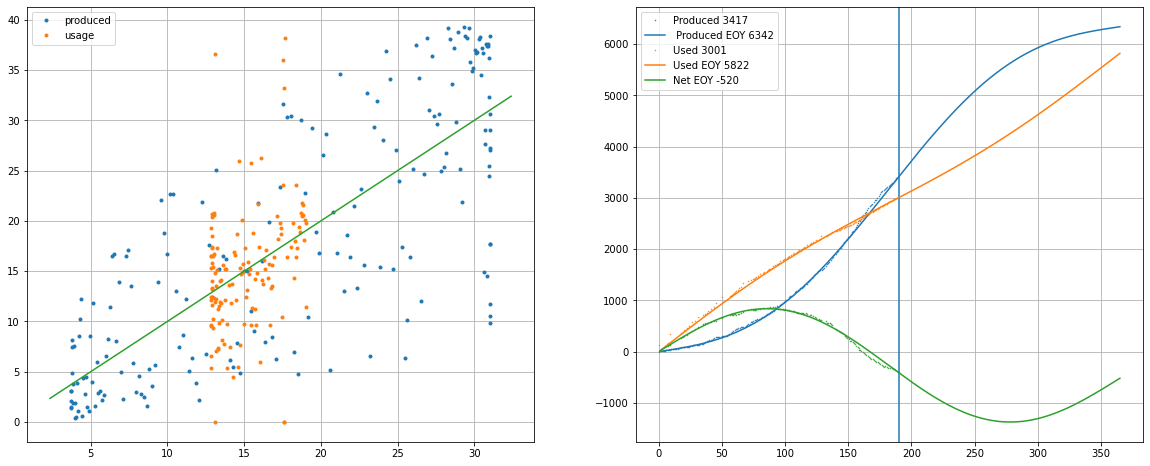

In [3]:

last_d = datetime(2023,7,1)
last_d=None
e=Energy(last_d=last_d)
folder = '/Users/manuel/Downloads/'

suffix = np.max([int(os.path.basename(x).replace('.csv','').split('_')[-1]) for x in glob.glob(os.path.join(folder,'3693411*.csv'))]).astype(str)
fn = os.path.join(folder,f'3693411_system_energy_20221218_to_{suffix}.csv')
e.load_produced(fn)
e.load_meter("/Users/manuel/OneDrive/Meterstanden.numbers")

e.produced_df
e.fit_production()
#e.plot_production()
e.compute_total_used()
e.fit_use()
#e.plot_usage()

e.plot()
(e.d0+timedelta(days=e.production_params[2]+365/2)).strftime('%d-%b')

In [4]:
f_tar = lambda x: e.cum_usage(x)-e.cum_production(x)
#sol = root_scalar(f_tar,x0=150,x1=270)
sol = minimize(f_tar,x0=250)
(e.d0+timedelta(days=sol.x[0])).strftime('%d-%b'),sol.fun

('05-Oct', -1373.9208101091126)

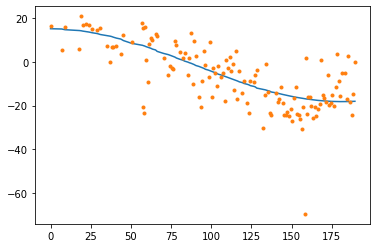

In [30]:
t=np.arange(1,366)
#plt.plot(t,e.usage(t))
#plt.plot(t,e.production(t))

ind = e.meter_df['t1']<2000
ind = ind & (e.meter_df['t0']>-1)
df_ = e.meter_df.loc[ind]
t1 = df_['t1'].values
t0 = df_['t0'].values
dt = t1-t0
plt.plot(t0,(e.cum_usage(t1)-e.cum_usage(t0)-e.cum_production(t1)+e.cum_production(t0))/dt)
plt.plot(t0,df_['net_used']/dt,'.')
#e.meter_df

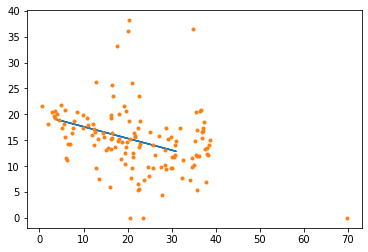

In [6]:
t=np.arange(1,366)
plt.plot(e.production(t),e.usage(t))
plt.plot(e.meter_df['produced']/e.meter_df['dt'],e.meter_df['used']/e.meter_df['dt'],'.')


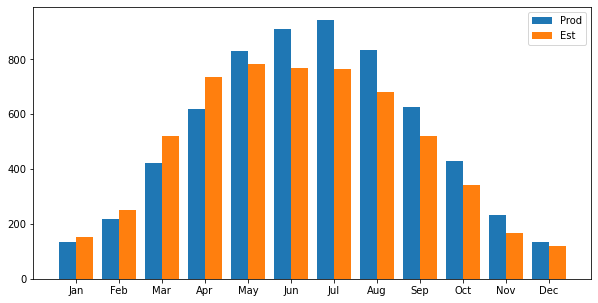

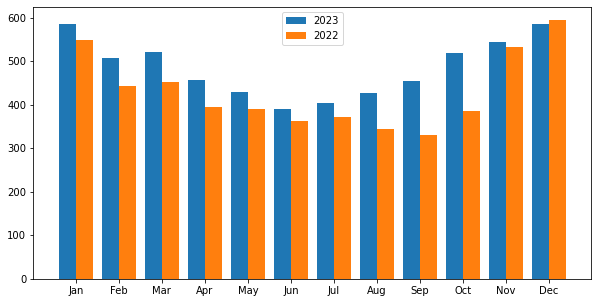

In [10]:
df = pd.DataFrame()
df['From']=[datetime(2023,i,1) for i in range(1,13)]
df['To']=[datetime(2023,i,1) for i in range(2,13)] +[datetime(2024,1,1)]
df['t0'] = [(x-datetime(2023,1,1))/timedelta(days=1) for x in df['From']]
df['t1'] = [(x-datetime(2023,1,1))/timedelta(days=1) for x in df['To']]
df['Produced']=np.round(e.cum_production(df['t1'])-e.cum_production(df['t0'])).astype(int)
df['Estimate'] = np.array([154,251,522,735,783,767,765,682,520,342,168,121])
df['Produced_cum']=np.round(e.cum_production(df['t1'])).astype(int)
df['Estimate_cum'] = df['Estimate'].cumsum()
df['Used']=np.round(e.cum_usage(df['t1'])-e.cum_usage(df['t0'])).astype(int)
df['Used_cum']=np.round(e.cum_usage(df['t1'])).astype(int)
df['Used 2022']=np.array([548.66,442.7,451.32,395.07,389.44,362.98,371.58,344.19,330.73,386.67,533.32,595])
df['Used 2022_cum']=df['Used 2022'].cumsum()


x=np.arange(1,13)
w=0.4
plt.figure(figsize=(10,5))
plt.bar(x-w/2,df['Produced'],width=w,label='Prod')
plt.bar(x+w/2,df['Estimate'],width=w,label='Est')

plt.xticks(x,[x.strftime('%b') for x in df['From']])
plt.legend()

x=np.arange(1,13)
w=0.4
plt.figure(figsize=(10,5))
plt.bar(x-w/2,df['Used'],width=w,label='2023')
plt.bar(x+w/2,df['Used 2022'],width=w,label='2022')

plt.xticks(x,[x.strftime('%b') for x in df['From']])
plt.legend()

In [8]:
df = e.produced_df.copy()
df = df.loc[df['from'].apply(lambda x: x.year==2023)]
df['YearMonth'] = df['from'].apply(lambda x: x.year*100+x.month)
df = df[['YearMonth','produced','model']].groupby('YearMonth',as_index=False).sum()
df['Produced_cum']=df['produced'].cumsum()
df['Model_cum']=df['model'].cumsum()
df

,YearMonth,produced,model,Produced_cum,Model_cum
0,202301,133.331,136.052890,133.331,136.052890
1,202302,250.085,218.156154,383.416,354.209044
2,202303,384.839,423.131148,768.255,777.340192
3,202304,616.814,619.655343,1385.069,1396.995535
4,202305,854.400,829.967432,2239.469,2226.962967
5,202306,954.394,911.153985,3193.863,3138.116952
6,202307,223.197,278.943092,3417.060,3417.060043


In [ ]:
e.produced_df.loc[e.produced_df['from'].apply(lambda x: x.year==2023),'produced'].sum(),e.cum_production((e.produced_df['to'].max()-datetime(2023,1,1))/timedelta(days=1))

(3392.5759999999996, array(3392.576))

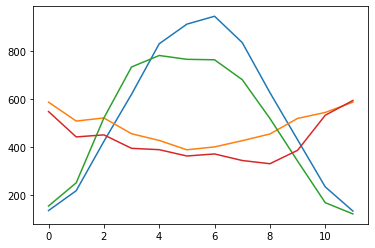

In [ ]:
estimate=np.array([154,251,522,735,783,767,765,682,520,342,168,121])
used_2022=np.array([548.66,442.7,451.32,395.07,389.44,362.98,371.58,344.19,330.73,386.67,533.32,595])
plt.plot(df['Produced'])
plt.plot(df['Used'])
plt.plot(estimate)
plt.plot(used_2022)

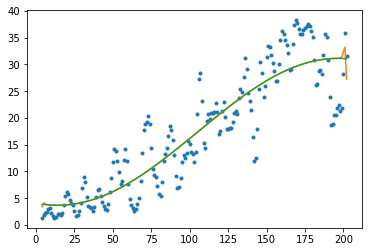

In [ ]:
df = e.produced_df.copy()

d=df['from'].apply(lambda x: (x - datetime(x.year,1,1))/timedelta(days=1))
df['model']=e.production(d.values)
t=df['t0'].values
eta=1.5
w=np.exp(-((t[:,None]-t[None,:])/eta)**2)
w = w/w.sum(axis=0)

df['avg']=w@ df['produced']
df['model_avg']=w@ df['model']

plt.plot(df['avg'],'.')
plt.plot(df['model_avg'])
plt.plot(df['model'])